In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import sys
import os
from dataclasses import dataclass
import json
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from llamawrapper import load_unemb_only, LlamaHelper
import seaborn as sns
from scipy.stats import bootstrap
from utils import plot_ci, plot_ci_plus_heatmap
from tqdm import tqdm

# fix random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
target_lang = 'fr'
model_size = '7b'
custom_model = None
out_dir = './visuals'

In [4]:
unemb = load_unemb_only(model_size)

Using 2 GPUs!


In [5]:
# prepare for energy plots
U = list(unemb.module[1].parameters())[0].detach().cpu().float()
weights = list(unemb.module[0].parameters())[0].detach().cpu().float()
print(f'U {U.shape} weights {weights.unsqueeze(0).shape}')
U_weighted = U.clone() 
#U_weighted = U_weighted / ((U_weighted**2).mean(dim=1, keepdim=True))**0.5
U_weighted *= weights.unsqueeze(0)
U_normalized = U_weighted / ((U_weighted**2).sum(dim=1, keepdim=True))**0.5
v = U.shape[0]
TT = U_normalized.T @ U_normalized
avgUU = (((U_normalized.T @ U_normalized)**2).sum() / v**2)**0.5

U torch.Size([32000, 4096]) weights torch.Size([1, 4096])


In [6]:
avgUU.item()

0.058621685951948166

In [7]:
prefix = "./data/langs/"
df_en_de = pd.read_csv(f'{prefix}{target_lang}/clean.csv')

In [8]:
if custom_model is not None:
    llama = LlamaHelper(dir=custom_model, load_in_8bit=True)
else:
    llama = LlamaHelper(dir='/dlabdata1/llama2_hf/Llama-2-%s-hf'%model_size, load_in_8bit=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
tokenizer = llama.tokenizer
model = llama.model

In [10]:
def token_prefixes(token_str: str):
    n = len(token_str)
    tokens = [token_str[:i] for i in range(1, n+1)]
    return tokens 

def add_spaces(tokens):
    return ['▁' + t for t in tokens] + tokens

def capitalizations(tokens):
    return list(set(tokens))

def unicode_prefix_tokid(zh_char = "云", tokenizer=tokenizer):
    start = zh_char.encode().__str__()[2:-1].split('\\x')[1]
    unicode_format = '<0x%s>'
    start_key = unicode_format%start.upper()
    if start_key in tokenizer.get_vocab():
        return tokenizer.get_vocab()[start_key]
    return None

def process_tokens(token_str: str, tokenizer, lang):
    with_prefixes = token_prefixes(token_str)
    with_spaces = add_spaces(with_prefixes)
    with_capitalizations = capitalizations(with_spaces)
    final_tokens = []
    for tok in with_capitalizations:
        if tok in tokenizer.get_vocab():
            final_tokens.append(tokenizer.get_vocab()[tok])
    if lang in ['zh', 'ru']:
        tokid = unicode_prefix_tokid(token_str, tokenizer)
        if tokid is not None:
            final_tokens.append(tokid)
    return final_tokens

id2voc = {id:voc for voc, id in llama.tokenizer.get_vocab().items()}
def get_tokens(token_ids, id2voc=id2voc):
    return [id2voc[tokid] for tokid in token_ids]

def compute_entropy(probas):
    return (-probas*torch.log2(probas)).sum(dim=-1)

lang2name = {'fr': 'Français', 'de': 'Deutsch', 'ru': 'Русский', 'en': 'English', 'zh': '中文'}

# German gap texts

In [14]:
key = "blank_prompt_translation_masked"
dataset_gap = []
n_skip = 2

for idx, (idx_df, row) in tqdm(enumerate(df_en_de.iterrows())):
    prompt_template = f''
    indices = set(list(range(len(df_en_de)))) - set([idx])
    idx_examples = np.random.choice(list(indices), n_skip, replace=False)
    prompt_template += f'{df_en_de[key][idx_examples[0]]}\n'
    prompt_template += f'{df_en_de[key][idx_examples[1]]}\n' 

    # get tok sets and kick out if intersection
    out_token_str = row['word_translation']
    latent_token_str = row['word_original']
    out_token_id = process_tokens(out_token_str, tokenizer, target_lang)
    latent_token_id = process_tokens(latent_token_str, tokenizer, 'en')
    intersection = set(out_token_id).intersection(set(latent_token_id))
    if len(out_token_id) == 0 or len(latent_token_id) == 0:
        continue
    if target_lang != 'en' and len(intersection) > 0:
        continue 
    if target_lang == 'zh':
        prompt = row[key].split("：")[0]+": \""
    else: 
        prompt = row[key].split(":")[0]+": \""
    dataset_gap.append({
        'prompt': prompt_template + prompt,
        'out_token_id': out_token_id,
        'out_token_str': out_token_str,
        'latent_token_id': latent_token_id,
        'latent_token_str': latent_token_str,
    })

118it [00:40,  2.93it/s]


In [15]:
len(dataset_gap)

57

In [16]:
df_gap = pd.DataFrame(dataset_gap)
print(df_gap['prompt'][0])

Une "___" est une zone basse entre des collines ou des montagnes, généralement traversée par une rivière. Réponse : "vallée".
Une "___" est une division sociale dans une société traditionnelle composée de familles ou de communautés liées par des liens sociaux, économiques, religieux ou de sang. Réponse : la "tribu".
Un "___" est une masse visible de vapeur d'eau condensée flottant dans l'atmosphère. Réponse : "


In [17]:
os.makedirs(f'{os.path.join(out_dir, custom_model)}/cloze', exist_ok=True)
df_gap.to_csv(f'{os.path.join(out_dir, custom_model)}/cloze/{target_lang}_dataset.csv', index=False)

In [18]:
latent_token_probs = []
out_token_probs = []
entropy = []
energy = [] 
latents_all = []

for idx, d in tqdm(enumerate(dataset_gap)):
    prompt = d['prompt']
    latents = llama.latents_all_layers(prompt)
    logits = unemb(latents)
    last = logits[:, -1, :].float().softmax(dim=-1).detach().cpu()
    latent_token_probs += [last[:, torch.tensor(d['latent_token_id'])].sum(axis=-1)]
    out_token_probs += [last[:, torch.tensor(d['out_token_id'])].sum(axis=-1)]
    entropy += [compute_entropy(last)]
    latents_all += [latents[:, -1, :].float().detach().cpu().clone()]
    latents_normalized = latents[:, -1, :].float()
    latents_normalized = latents_normalized / (((latents_normalized**2).mean(dim=-1, keepdim=True))**0.5)
    latents_normalized /= (latents_normalized.norm(dim=-1, keepdim=True))
    norm = ((U_normalized @ latents_normalized.T)**2).mean(dim=0)**0.5
    energy += [norm/avgUU]

latent_token_probs = torch.stack(latent_token_probs)
out_token_probs = torch.stack(out_token_probs)
entropy = torch.stack(entropy)
energy = torch.stack(energy)
latents = torch.stack(latents_all)

57it [01:56,  2.05s/it]


/dlabdata1/wendler/code/llm-latent-language/utils.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


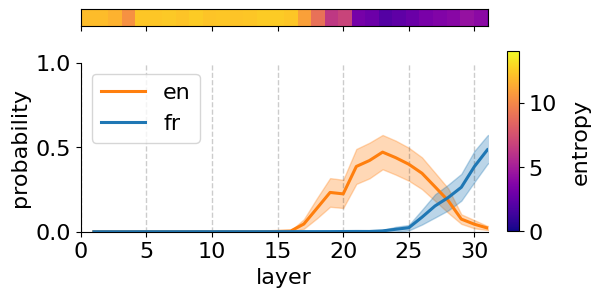

In [19]:
size2tik = {'7b': 5, '13b': 5, '70b': 10}

fig, ax, ax2 = plot_ci_plus_heatmap(latent_token_probs, entropy, 'en', color='tab:orange', tik_step=size2tik[model_size], do_colorbar=True,
nums=[.99, 0.18, 0.025, 0.6])
if target_lang != 'en':
    plot_ci(ax2, out_token_probs, target_lang, color='tab:blue', do_lines=False)
ax2.set_xlabel('layer')
ax2.set_ylabel('probability')
if model_size == '7b':
    ax2.set_xlim(0, out_token_probs.shape[1]+1)
else:
    ax2.set_xlim(0, round(out_token_probs.shape[1]/10)*10+1)
ax2.set_ylim(0, 1)
#ax2.set_xticks(np.arange(0, out_token_probs.shape[1], size2tik[model_size]), np.arange(1, out_token_probs.shape[1]+1, size2tik[model_size]))
ax2.set_xlim(0, round(out_token_probs.shape[1]/10)*10+1)
# put legend on the top left
ax2.legend(loc='upper left')
os.makedirs(f'{os.path.join(out_dir, custom_model)}/cloze', exist_ok=True)
plt.savefig(f'{os.path.join(out_dir, custom_model)}/cloze/{model_size}_{target_lang}_probas_ent.pdf', dpi=300, bbox_inches='tight')

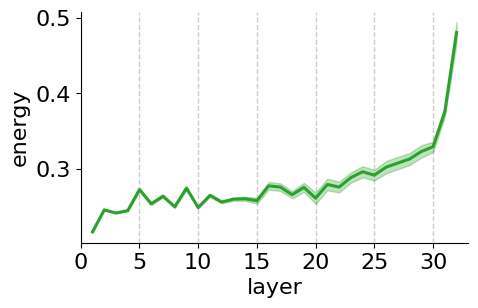

In [20]:
fig, ax2 = plt.subplots(figsize=(5,3))
plot_ci(ax2, energy, 'energy', color='tab:green', do_lines=True, tik_step=size2tik[model_size])
ax2.set_xlabel('layer')
if model_size == '7b':
    ax2.set_ylabel('energy')
    ax2.set_xlim(0, out_token_probs.shape[1]+1)
else:
    ax2.set_xlim(0, round(out_token_probs.shape[1]/10)*10+1)
os.makedirs(f'{os.path.join(out_dir, custom_model)}/cloze', exist_ok=True)
plt.savefig(f'{os.path.join(out_dir, custom_model)}/cloze/{model_size}_{target_lang}_energy.pdf', dpi=300, bbox_inches='tight')

In [21]:
torch.save(latents, f'{os.path.join(out_dir, custom_model)}/cloze/{model_size}_{target_lang}_latents.pt')